# Currency exchange example

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great British pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New Zealand dollar (NZD)
- South Korean won (KRW)
- Mexican peso (MXN)

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import torch
import numpy as np
import pandas as pd

torch.manual_seed(1);

## Data loading

In [2]:
column_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
                'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

dataset = mogptk.DataSet()
for names in column_names:
    dataset.append(mogptk.LoadCSV('data/currency_exchange/final_dataset.csv',
                                    x_col='Date', y_col=names))

dataset.filter('2017-01-03', '2018-01-01')

In [3]:
# Preprocess by randomly removing points and detrending
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.transform(mogptk.TransformNormalize())
    channel.remove_randomly(pct=0.3)
    
    if i not in [0, 2, 5]:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

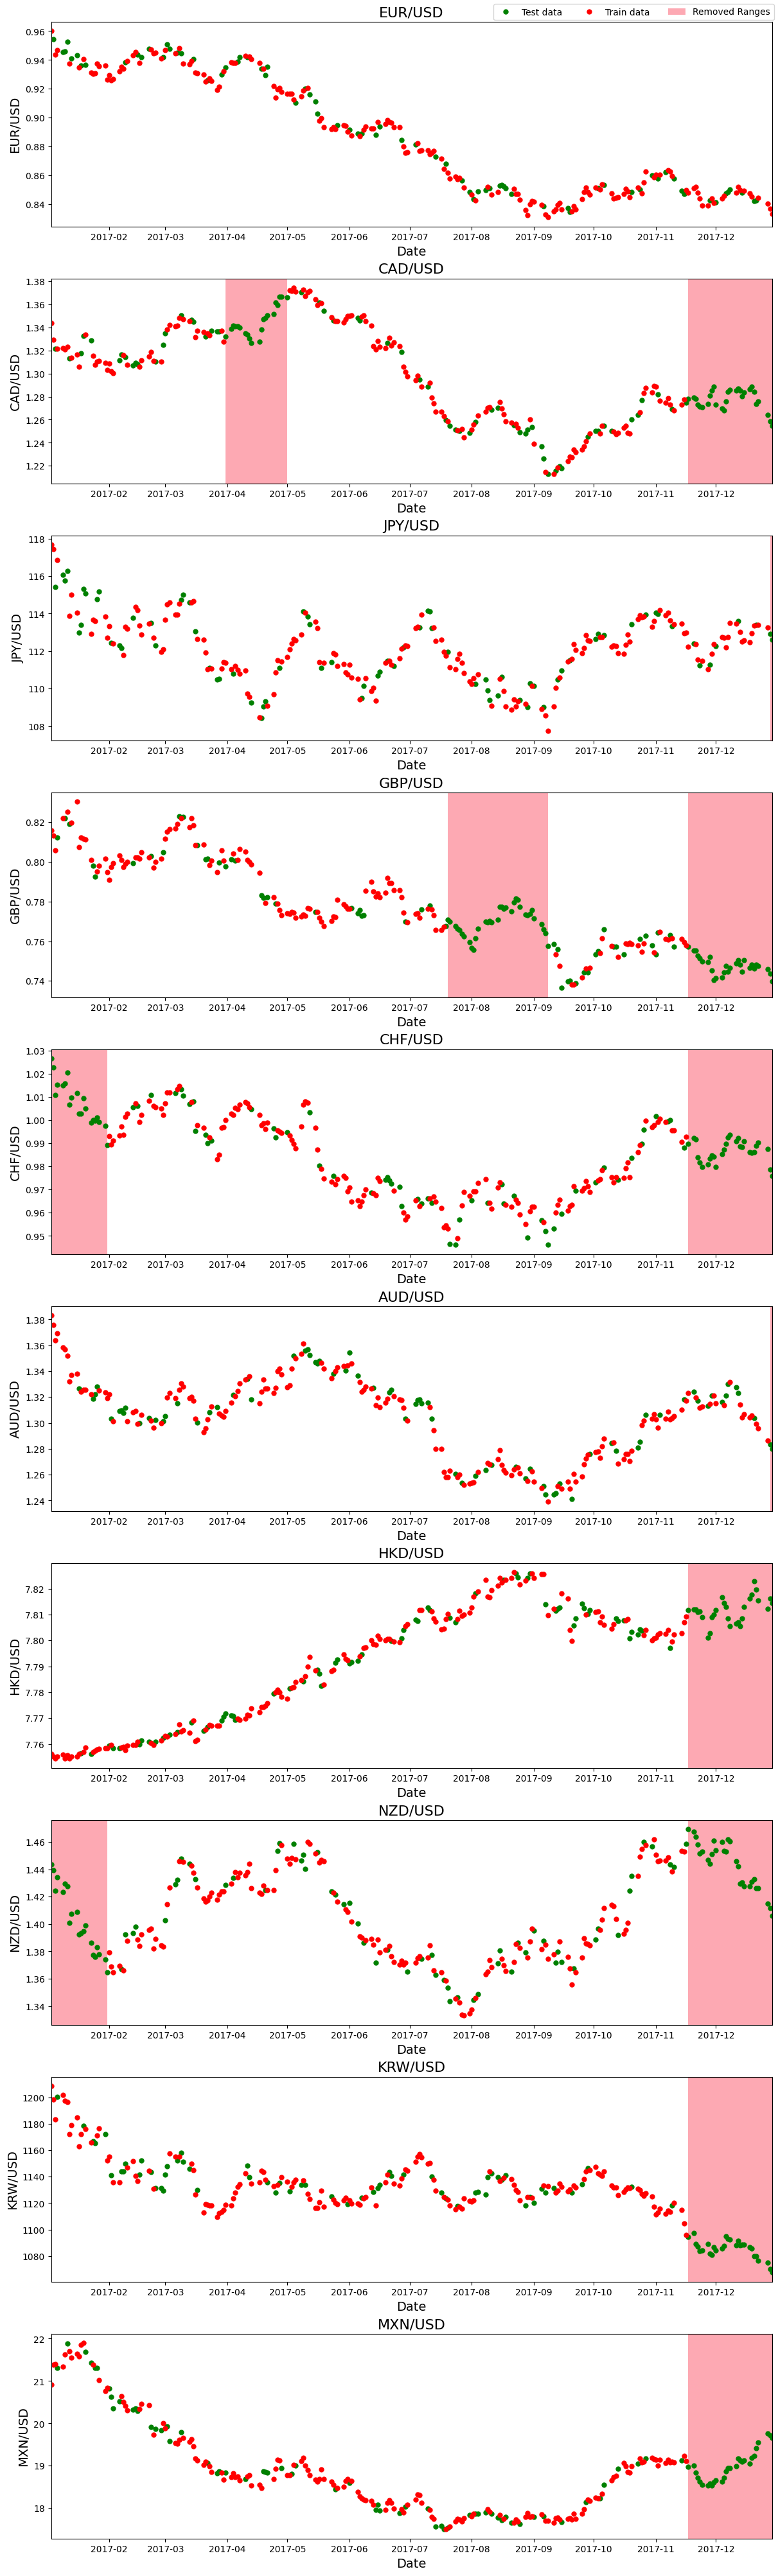

In [4]:
dataset.plot();

In [5]:
n_trials = 3
Q = 3
init_method = 'BNSE'
method = 'Adam'
lr = 0.1
iters = 1000

## Multi-output spectral mixture kernel

In [6]:
mosm_models = []
mosm_mae = np.zeros((n_trials,10))
mosm_rmse = np.zeros((n_trials,10))
mosm_mape = np.zeros((n_trials,10))

# experiment trials
for n in range(n_trials):
    mosm_dataset = dataset.copy()
    for i, channel in enumerate(mosm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=Q)
    mosm.init_parameters(init_method)
    mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 160
‣ Training points: 1067
‣ Iterations: 1000
     0/1000   0:00:16  loss=     372.156 (warmup)
     2/1000   0:01:17  loss=      387.18
    18/1000   0:01:20  loss=     234.751
    94/1000   0:01:30  loss=    -166.447
   171/1000   0:01:40  loss=    -204.738
   247/1000   0:01:50  loss=    -236.755
   322/1000   0:02:00  loss=    -245.181
   397/1000   0:02:10  loss=    -199.653
   473/1000   0:02:20  loss=    -259.147
   548/1000   0:02:30  loss=    -267.594
   624/1000   0:02:40  loss=    -267.126
   700/1000   0:02:50  loss=    -278.228
   776/1000   0:03:00  loss=    -166.826
   850/1000   0:03:10  loss=    -286.286
   925/1000   0:03:20  loss=    -316.283
  1000/1000   0:03:29  loss=    -305.608
Optimization finished in 3 minutes 29 seconds

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kerne

In [7]:
pd.DataFrame(np.c_[mosm_mae.mean(1), mosm_rmse.mean(1), mosm_mape.mean(1),
             mosm_mae.std(1), mosm_rmse.std(1), mosm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

MAE      RMSE      MAPE   MAE std  RMSE std  MAPE std
0  1.424521  2.134517  0.816759  3.948284  5.973529  0.381060
1  0.762996  1.003298  0.730678  1.990932  2.622035  0.303361
2  1.143211  1.502700  0.760170  3.157059  4.145439  0.300203

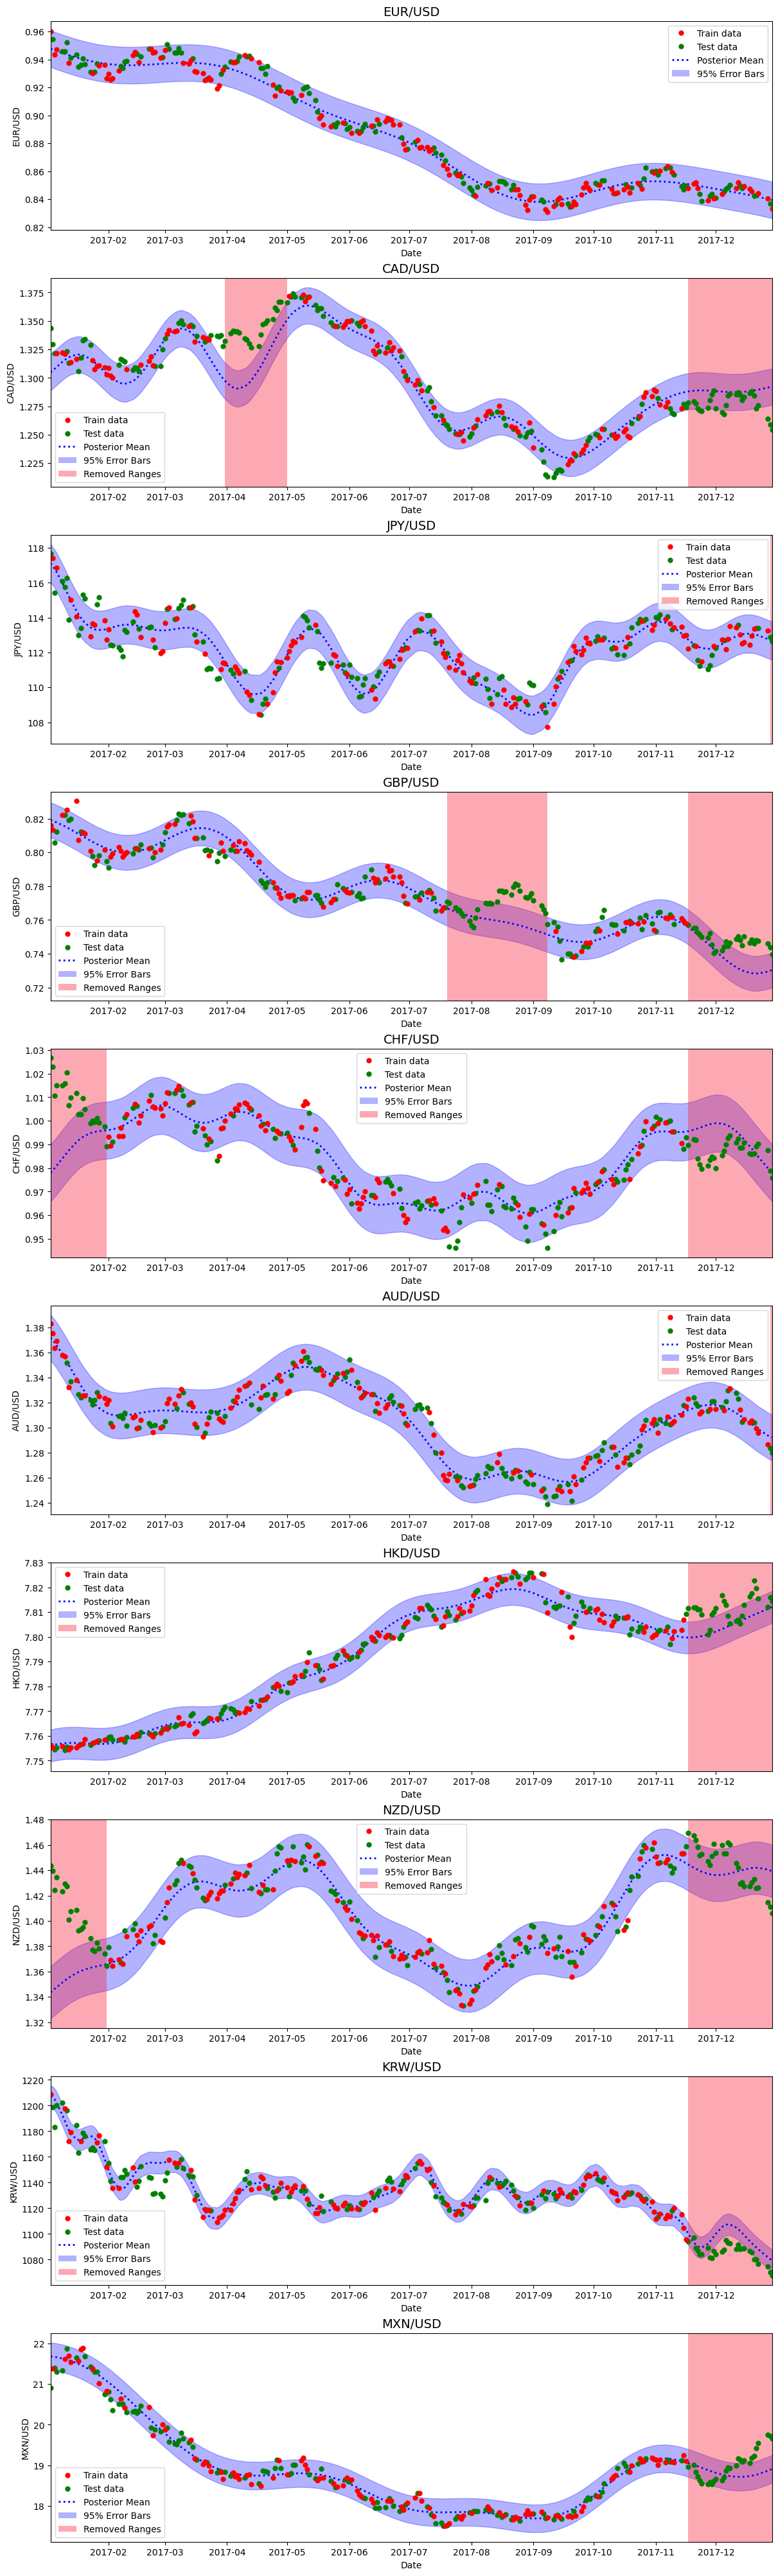

In [8]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction();

## Cross spectral mixture kernel

In [9]:
csm_models = []
csm_mae = np.zeros((n_trials,10))
csm_rmse = np.zeros((n_trials,10))
csm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    for i, channel in enumerate(csm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=Q)
    csm.init_parameters(init_method)    
    csm.train(method=method, lr=lr, iters=iters, verbose=True)
    csm_models.append(csm)
    print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MixtureKernel['CrossSpectralKernel', 'CrossSpectralKernel', 'CrossSpectralKernel']
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 76
‣ Training points: 1075
‣ Iterations: 1000
     0/1000   0:00:27  loss=     601.512 (warmup)
     2/1000   0:02:40  loss=      453.24
    55/1000   0:02:50  loss=     70.6357
   109/1000   0:03:00  loss=    -76.5361
   163/1000   0:03:10  loss=    -125.643
   218/1000   0:03:20  loss=    -145.775
   272/1000   0:03:30  loss=    -150.338
   327/1000   0:03:40  loss=    -155.408
   381/1000   0:03:50  loss=     -161.76
   436/1000   0:04:00  loss=     -162.39
   490/1000   0:04:10  loss=    -162.668
   544/1000   0:04:20  loss=    -162.338
   599/1000   0:04:30  loss=    -163.379
   654/1000   0:04:40  loss=    -164.088
   708/1000   0:04:50  loss=    -164.429
   763/1000   0:05:00  loss=    -164.581
   818/1000   0:05:10  loss=    -163.493
   873/1000   0:05:20  loss

In [10]:
pd.DataFrame(np.c_[csm_mae.mean(1), csm_rmse.mean(1), csm_mape.mean(1),
             csm_mae.std(1), csm_rmse.std(1), csm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

MAE      RMSE      MAPE   MAE std  RMSE std  MAPE std
0  0.990018  1.289088  0.828820  2.531145  3.291015  0.384047
1  0.894034  1.182334  0.813442  2.245169  2.974195  0.360703
2  0.981467  1.295573  0.802904  2.486301  3.297500  0.344625

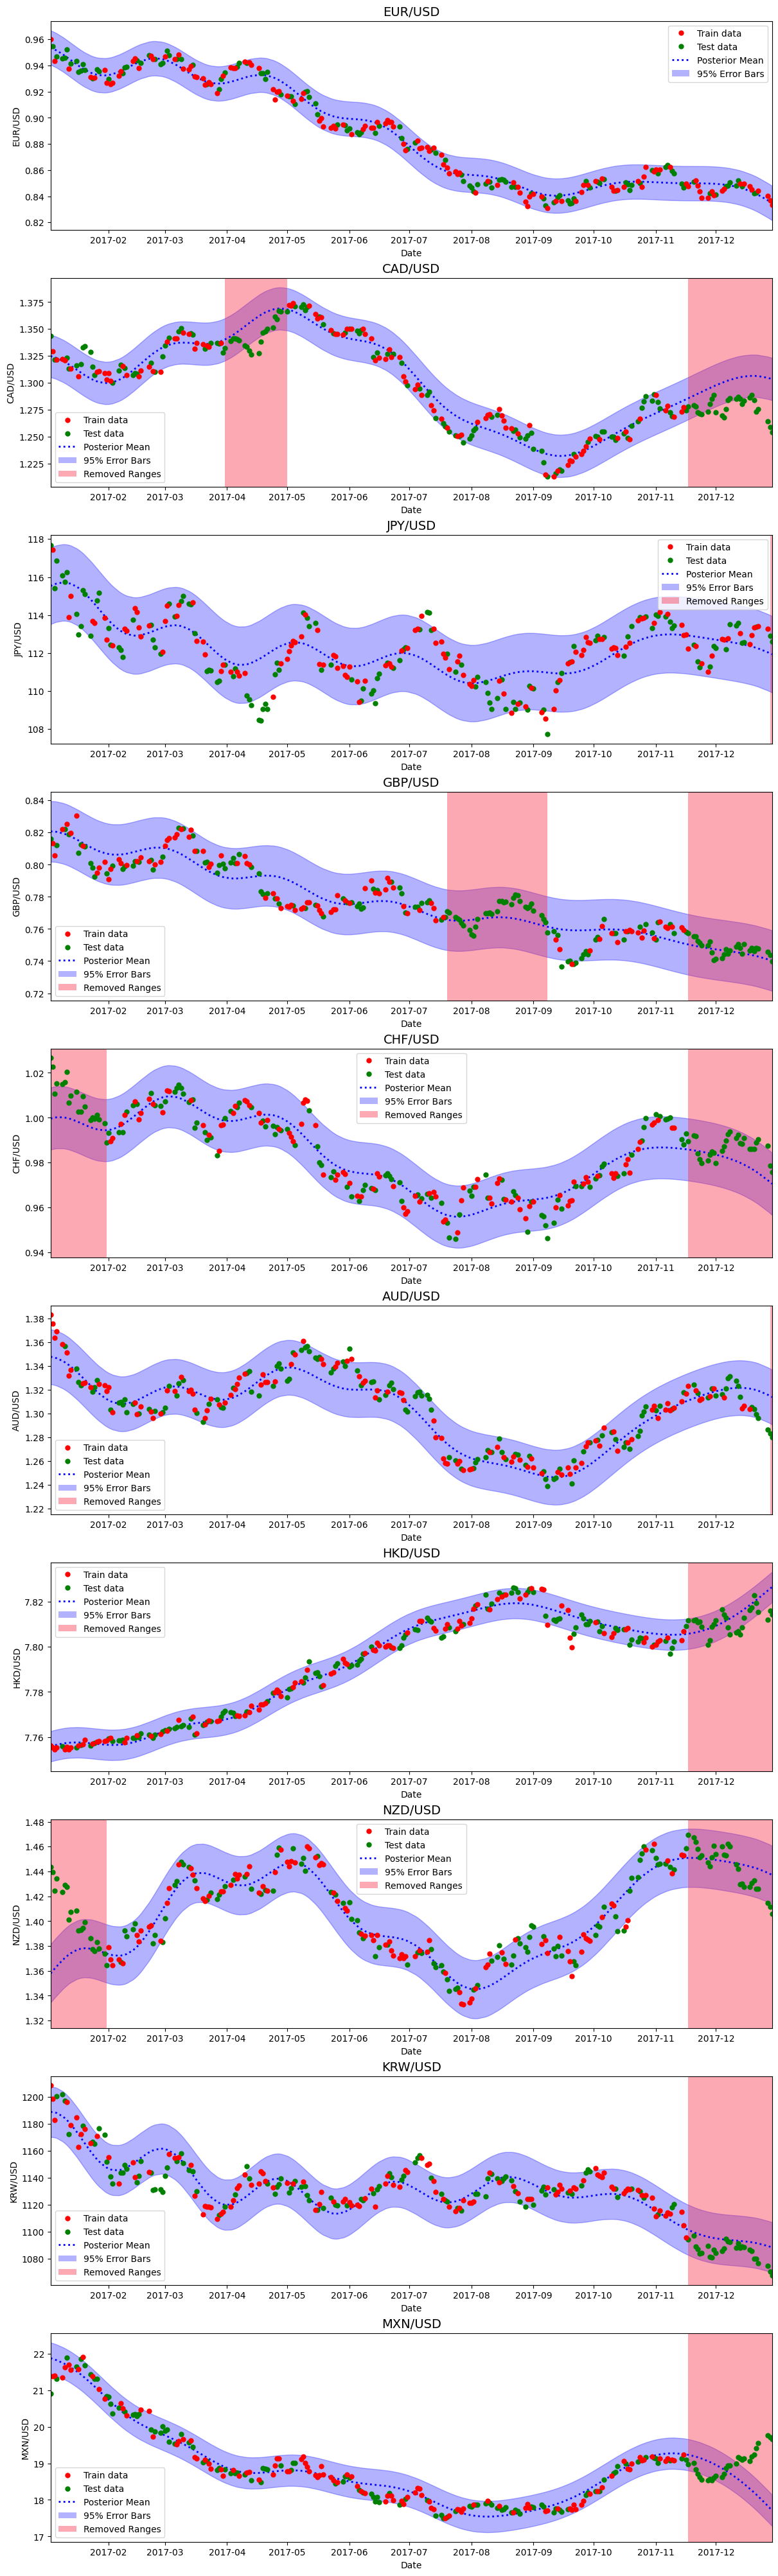

In [11]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction();

## Linear model of coregionalization with spectral mixture kernels

In [12]:
smlmc_models = []
smlmc_mae = np.zeros((n_trials,10))
smlmc_rmse = np.zeros((n_trials,10))
smlmc_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    for i, channel in enumerate(smlmc_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=Q)
    smlmc.init_parameters(init_method)
    smlmc.train(method=method, lr=lr, iters=iters, verbose=True)
    smlmc_models.append(smlmc)
    print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: LinearModelOfCoregionalizationKernel['SpectralKernel', 'SpectralKernel', 'SpectralKernel']
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 46
‣ Training points: 1079
‣ Iterations: 1000
     0/1000   0:00:14  loss=     589.172 (warmup)
     2/1000   0:01:52  loss=     565.024
    68/1000   0:02:00  loss=     214.408
   170/1000   0:02:10  loss=     124.878
   272/1000   0:02:20  loss=     109.457
   375/1000   0:02:30  loss=     105.879
   477/1000   0:02:40  loss=     104.072
   577/1000   0:02:50  loss=     103.038
   677/1000   0:03:00  loss=     102.352
   777/1000   0:03:10  loss=     101.886
   878/1000   0:03:20  loss=     101.505
   980/1000   0:03:30  loss=     101.196
  1000/1000   0:03:32  loss=     101.139
Optimization finished in 3 minutes 32 seconds

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: LinearModelOfCoregionalizationKernel['SpectralKernel', 'Spectra

In [13]:
pd.DataFrame(np.c_[smlmc_mae.mean(1), smlmc_rmse.mean(1), smlmc_mape.mean(1),
             smlmc_mae.std(1), smlmc_rmse.std(1), smlmc_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

MAE      RMSE      MAPE   MAE std  RMSE std  MAPE std
0  1.138076  1.406304  0.849786  3.030571  3.721089  0.286675
1  1.265233  1.480022  0.742775  3.370088  3.888276  0.308673
2  1.183561  1.504745  0.882608  3.113238  3.930786  0.271166

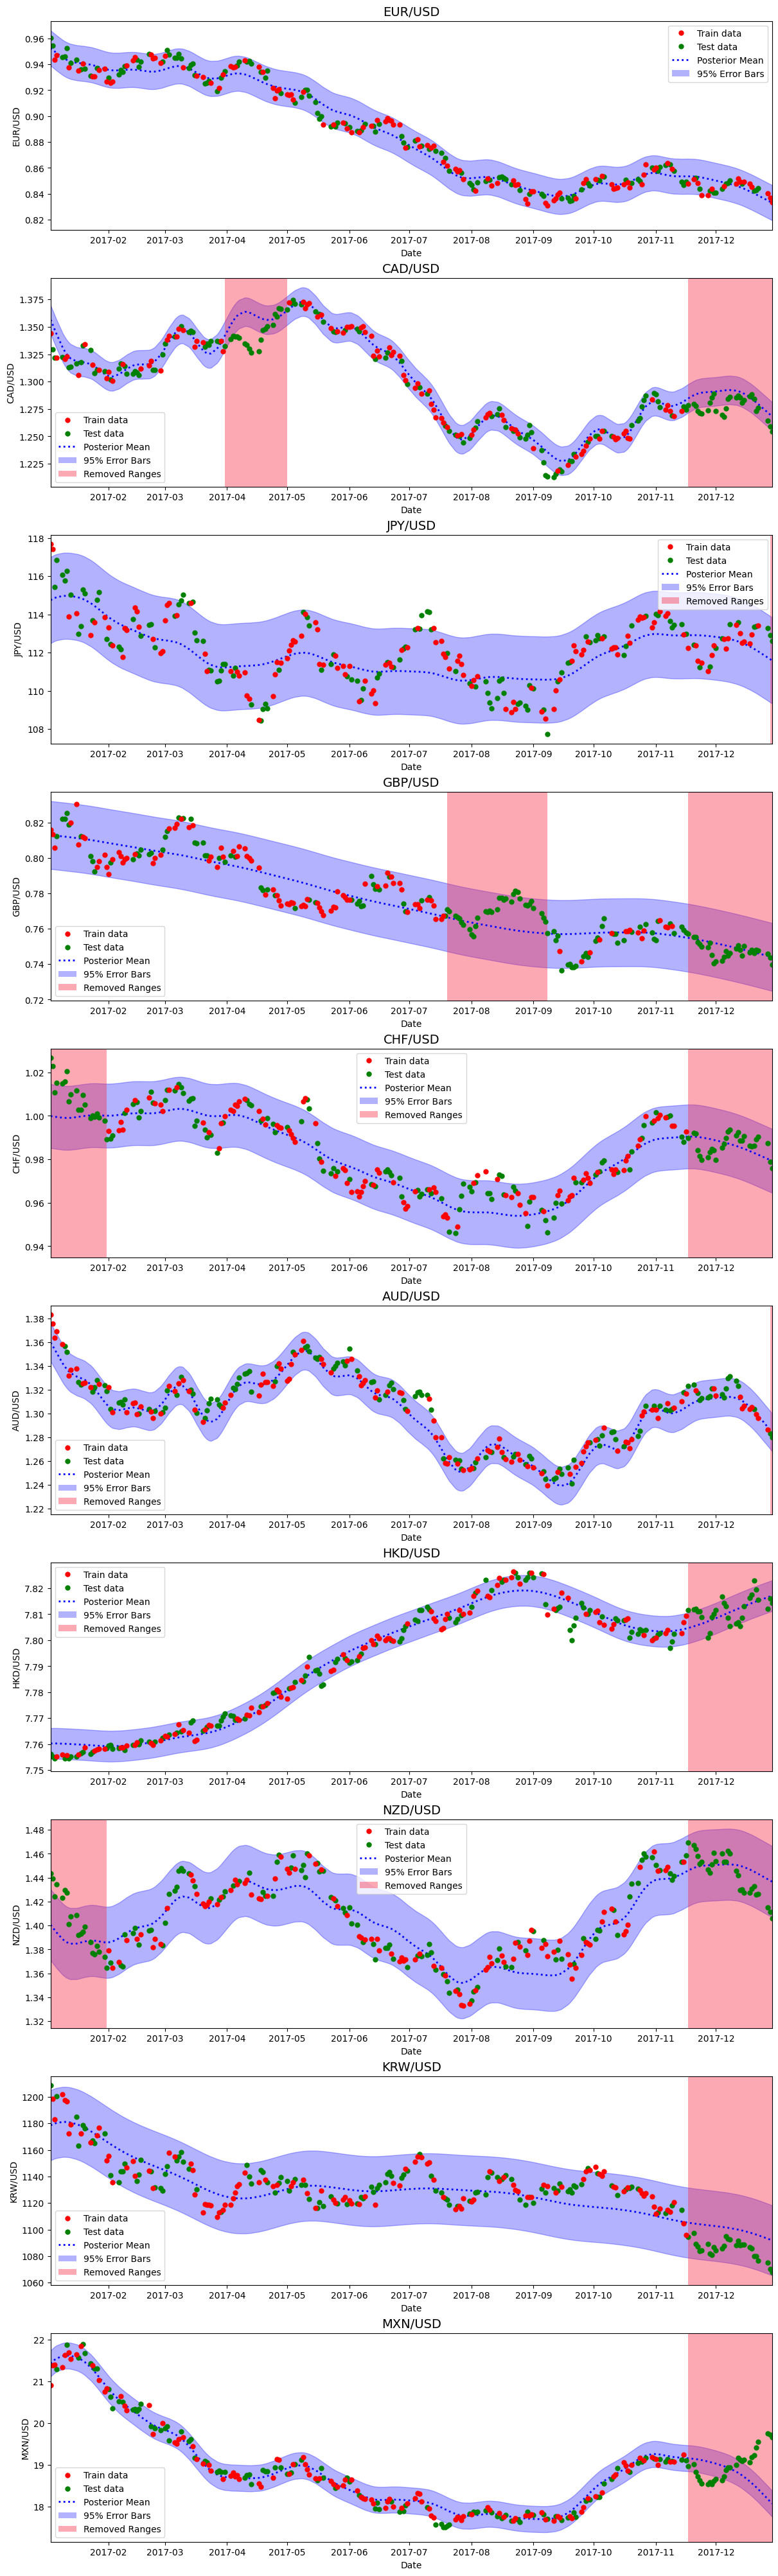

In [14]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction();

## Independent spectral mixture kernels

In [15]:
sm_models = []
sm_mae = np.zeros((n_trials,10))
sm_rmse = np.zeros((n_trials,10))
sm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    for i, channel in enumerate(sm_dataset):
        channel.remove_randomly(pct=0.3)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=Q)
    sm.init_parameters(init_method)
    sm.train(method=method, lr=lr, iters=iters, verbose=True)
    sm_models.append(sm)
    print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 100
‣ Training points: 1080
‣ Iterations: 1000
     0/1000   0:00:03  loss=     367.354 (warmup)
     2/1000   0:00:17  loss=      345.31
    41/1000   0:00:20  loss=     44.1248
   189/1000   0:00:30  loss=    -295.224
   333/1000   0:00:40  loss=    -334.987
   478/1000   0:00:50  loss=    -342.512
   624/1000   0:01:00  loss=    -349.572
   774/1000   0:01:10  loss=    -350.634
   924/1000   0:01:20  loss=    -351.051
  1000/1000   0:01:25  loss=    -351.158
Optimization finished in 1 minute 25 seconds

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 100
‣ Training points: 1089
‣ Iterations: 1000
     0/1000   0:00:03  loss=     366.976 (warmup)
     2/1000   0:00:17  loss=     345.736
    38/1000   0:0

In [16]:
pd.DataFrame(np.c_[sm_mae.mean(1), sm_rmse.mean(1), sm_mape.mean(1),
             sm_mae.std(1), sm_rmse.std(1), sm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

MAE      RMSE      MAPE   MAE std  RMSE std  MAPE std
0  0.838421  1.181028  0.661005  2.251060  3.204024  0.311735
1  1.376325  1.953592  0.685324  3.886168  5.529192  0.349559
2  1.208032  1.667259  0.685434  3.364896  4.668012  0.347804

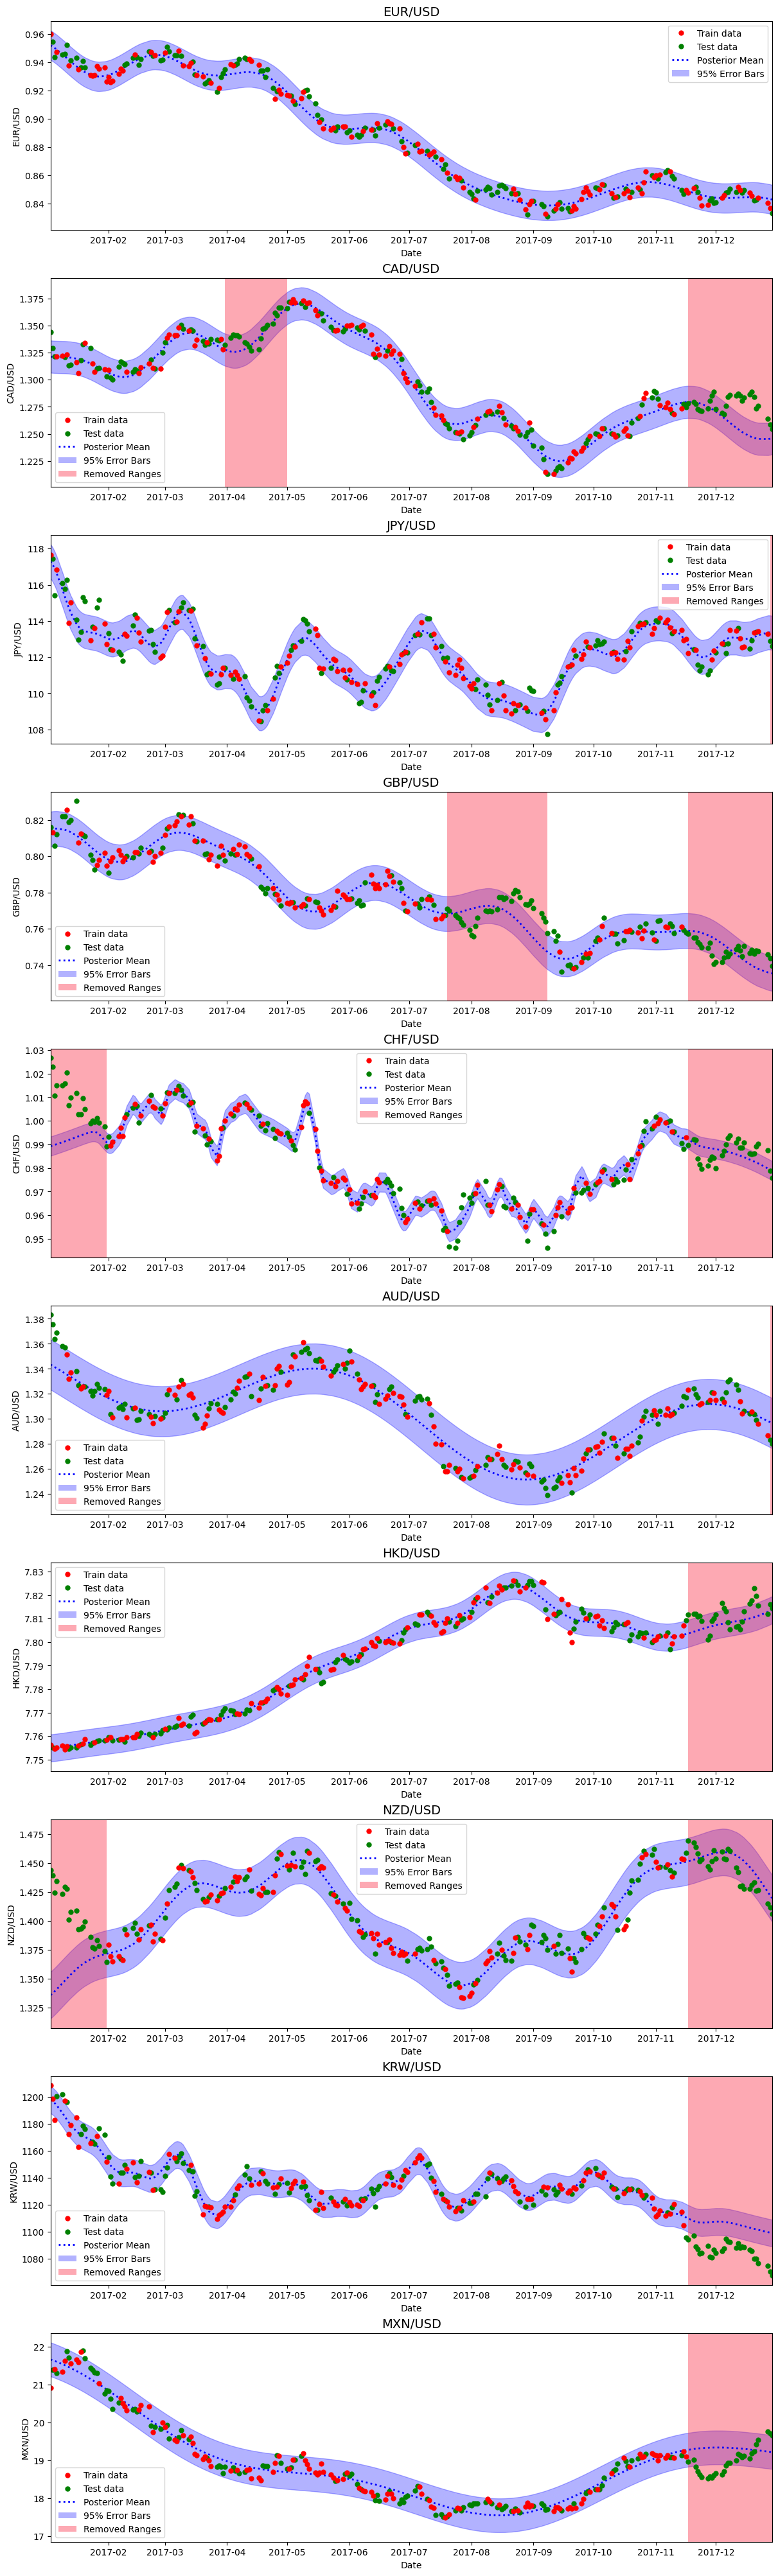

In [17]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction();

## Results

In [18]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    0.769203 ± 0.0357181
CSM:     0.815055 ± 0.0106413
SM-LMC:  0.825056 ± 0.0597046
SM:      0.677255 ± 0.0114902
